<a href="https://colab.research.google.com/github/SaharaAli16/ArcticSeaIce_Research/blob/main/MTCINet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Multistream TCINet on GrIS Data
### Last Updated
April 29. 2024

In [ ]:
#from numpy.random import seed
#seed(1)

In [ ]:
#while True:pass

## Time-Series Causal Inference

## Initial Setup

In [ ]:
import os
import math
import glob
import numpy as np
import pandas as pd
from math import sqrt
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, Dropout
from tensorflow.keras.layers import Concatenate, TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras import Model
from tensorflow.keras.losses import Loss

## Functional Structure Needed

In [ ]:
# 1. Load Data from File

file = '/content/GrIS_regional_ERA5_ablation_JJA_mean_1990_2021.csv'
data = data_loader(file)

# Input to take from user on the given dataset
lag = 2
tr_factor =  1.074 #multiplicative factor for treatment
timesteps = 1 #window size for Model

#Create a 4 by 4 Adjacency Matrix to Store the ATE values
ate_matrix = np.zeros((data.shape[1]-1, data.shape[1]-1))

tr_id = -1 #index for treatment
target_id = -2 #index for outcome

# Create a loop for iterating over treatment, and outcome variables
#for tr_id in range(data.shape[1]-1): #data.shape[1]
#  for target_id in range(data.shape[1]-1): #data.shape[1]
#    print("--------------------------------------------------------------------------")
#    print("Running loop for Treatment_ID: "+str(tr_id+1)+" and Outcome_ID: "+ str(target_id+1))
#    print("--------------------------------------------------------------------------")
    # 2. Call Data Parser for individual CI data modules like lagged treatment, lagged outcome, etc

tr, tr_hist, cov, target_hist, target, cf = lagged_data_parser(data, lag, tr_id, target_id, cf_id=-1) # add lag to treatment and target
print(tr.shape, tr_hist.shape, cov.shape, target_hist.shape, target.shape, cf.shape)

    # concatenates history block and intervention block
hist, inter = intervention_data_loader(tr, tr_hist, target_hist)

    # 3. Train-Test-Treatment Split of Data
hist_train, inter_train, target_train, hist_test, inter_test, target_test, treated = train_test_treat_splitter(hist, inter, target, tr_factor)

    # 4. Normalize Data
scaler_f, scaler_tr, scaler_l, hist_train, hist_test, inter_train, inter_test, treated, target_train, target_test = data_normalizer(hist_train, hist_test, inter_train, inter_test, treated, target_train, target_test)

    # 5. Reshape Data
hist_train = reshape_features(hist_train, timesteps) # reshaping to 3d for model
hist_test = reshape_features(hist_test, timesteps) # reshaping to 3d for model

inter_train = reshape_features(inter_train, timesteps) # reshaping to 3d for model
inter_test = reshape_features(inter_test, timesteps) # reshaping to 3d for model

treated = reshape_features(treated, timesteps) # reshaping to 3d for model

print("hist_train, hist_test, inter_train, inter_test, treated",(hist_train.shape, hist_test.shape, inter_train.shape, inter_test.shape, treated.shape))

    # 6. Specifying Loss Function
loss_fn = tf.keras.losses.MeanSquaredError() #specify the loss

    # 7. Building Model and Compiling the Network
input1_shape = (timesteps, hist_train.shape[2])
input2_shape = (timesteps, inter_train.shape[2])
out_dim1 = hist_train.shape[2]
out_dim2 = 1
model = build_mtcinet_model(input1_shape, input2_shape, out_dim1, out_dim2, loss_fn)
print(model.summary())

checkpoint_path='./mymodel.h'
keras_callbacks   = [
    EarlyStopping(monitor='val_loss', patience=6, mode='min', min_delta=0.001),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
  ]
    #Plotting the model as image (optional)
    #tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='slearner.png')
    #from IPython.display import Image # this just Jupyter notebook stuff
    #Image(retina=True, filename='slearner.png')

    # 8. Fitting the Model on Train Data
history=model.fit(x=[hist_train,inter_train],y=[hist_train,target_train], epochs=50, batch_size=64, verbose=1, validation_split=0.2, shuffle=False,callbacks=keras_callbacks)

    # 9. Outcome Predictions
hist_train_pred, train_pred = model.predict([hist_train,inter_train])
hist_test_pred, test_pred = model.predict([hist_test,inter_test])
_, cf_pred = model.predict([hist_test,treated])

    #Inverse transform the predictions
test_pred = scaler_l.inverse_transform(test_pred)
target_test = scaler_l.inverse_transform(target_test)
cf_pred = scaler_l.inverse_transform(cf_pred)
hist_test = scaler_f.inverse_transform(hist_test.reshape(-1,hist_test.shape[2]))
hist_test_pred = scaler_f.inverse_transform(hist_test_pred.reshape(-1,hist_test_pred.shape[2]))


    #RMSE of Test Data
rmse = sqrt(mean_squared_error(target_test, test_pred))
rmse_x = sqrt(mean_squared_error(hist_test[:,0], hist_test_pred[:,0]))
rmse_cov = sqrt(mean_squared_error(hist_test[:,1:], hist_test_pred[:,1:]))
#rmse_cf = sqrt(mean_squared_error(cf[:29997], cf_pred[:29997]))
print('Test RMSE: %.3f' % rmse)
#print('Treated RMSE: %.3f' % rmse_cf)
print('Test Reconstruction Treatment RMSE: %.3f' % rmse_x)
print('Test Reconstruction Covariate RMSE: %.3f' % rmse_cov)

    # 10. Causal Effect Estimation
cate_pred=(cf_pred[-test_pred.shape[0]:]-test_pred).squeeze()

ate_pred=np.mean(cate_pred)
    #PEHE: only works in case of true cause
    #pehe=np.mean( np.square( ( cate_true - cate_pred) ) )
    #sqrt_pehe=np.sqrt(pehe)
    #print("\nSQRT PEHE:",sqrt_pehe)
ate_matrix[tr_id, target_id] = ate_pred

    # 11. Printing out results
print("Estimated ATE for "+"Treatment: S"+str(tr_id+1)+" and Outcome: S"+str(target_id+1)+" is:",ate_pred)

print(ate_matrix)
np.save("ate_matrix.npy",ate_matrix)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SWDN        118 non-null    float64
 1   LWDN        118 non-null    float64
 2   T2M         118 non-null    float64
 3   TCC         118 non-null    float64
 4   RACMO_Snow  118 non-null    float64
 5   GBI         118 non-null    float64
dtypes: float64(6)
memory usage: 5.7 KB
None
(115,) (115,) (115, 4) (115,) (115,) (115,)
(115, 5) (115, 2)
LEN_DATA: 115
NUM_TRAIN: 80
NUM_VALID: 35
(37, 5) (37, 2) (37,)
hist.shape: (115, 5)
inter.shape: (115, 2)
target.shape: (115,)
hist_test.shape: (37, 5)
inter_test.shape: (37, 2)
target_test.shape: (37,)
treated.shape: (37, 2)
(115, 5)
(37, 5)
(115, 2)
(37, 2)
(37, 2)
hist_train, hist_test, inter_train, inter_test, treated ((115, 1, 5), (37, 1, 5), (115, 1, 2), (37, 1, 2), (37, 1, 2))
Model: "model_3"
________________________________________________________

In [ ]:
print(ate_matrix(l))

[[ 1.45603083e-02 -2.31945533e-02  9.35066864e-03  3.20467782e+00]
 [-1.19612174e-04 -7.72525455e-05 -2.72764391e-05 -2.86022496e+00]
 [-2.57471489e-04  1.53070944e-03  4.21833684e-05  3.62307892e+01]
 [ 5.55717907e-06 -1.07543101e-05  3.96699477e-07  2.17312500e-02]]


### Plotting the Results

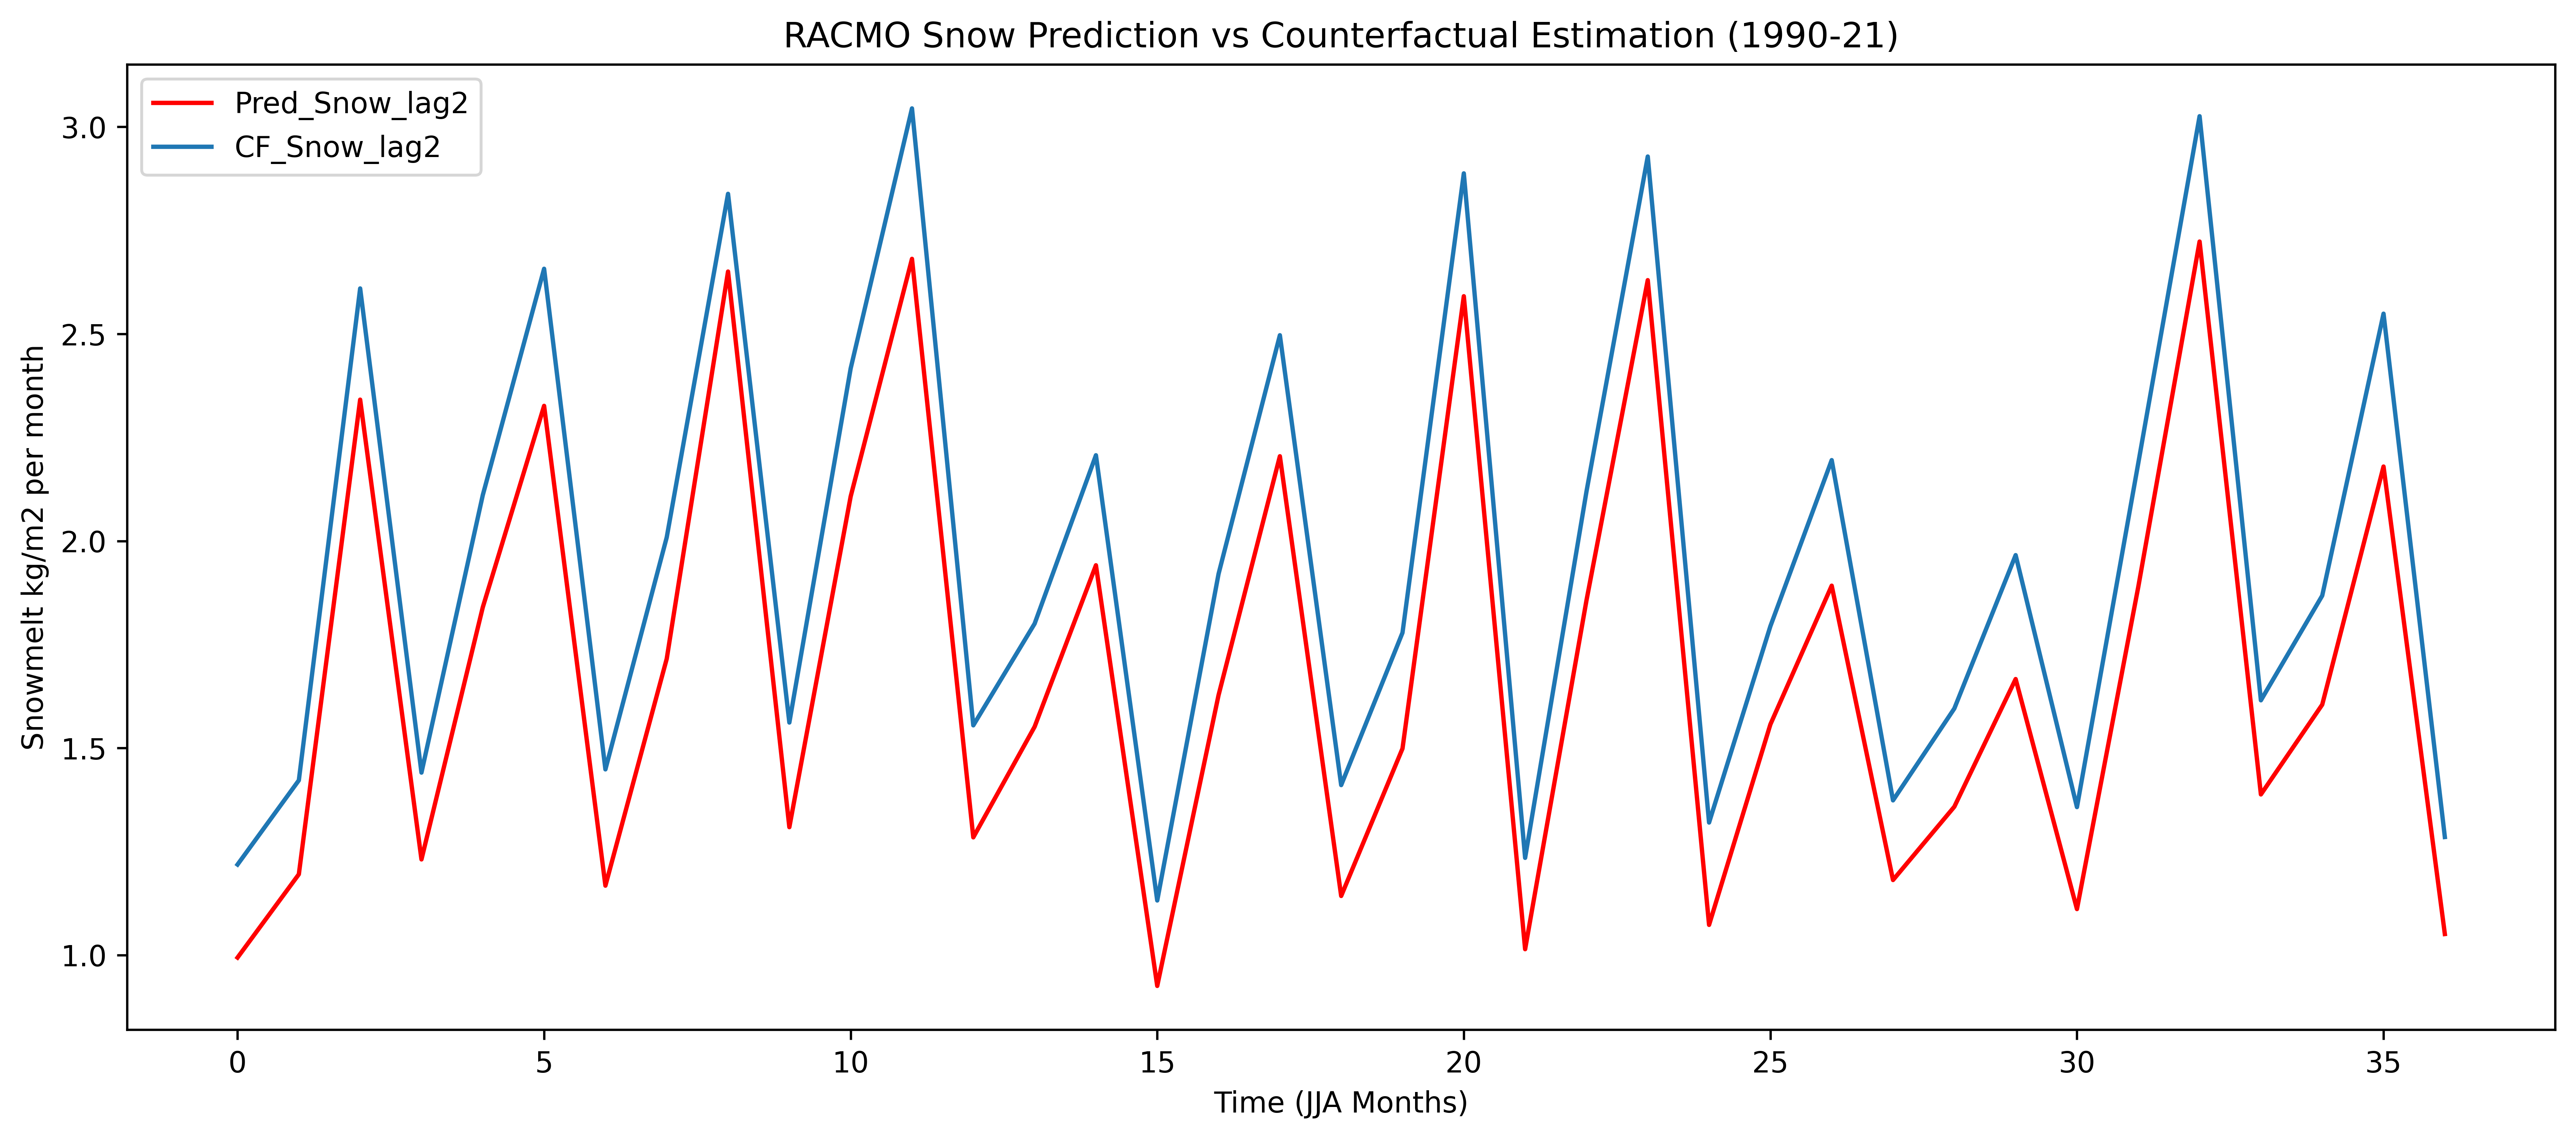

In [ ]:
%matplotlib inline
#plot
fig, ax= plt.subplots(figsize=(15, 6), dpi = 600)
plt.plot(test_pred, color='red')
plt.plot(cf_pred)

plt.legend(['Pred_Snow_lag2','CF_Snow_lag2'])
plt.title("RACMO Snow Prediction vs Counterfactual Estimation (1990-21)")
ax.set_xlabel("Time (JJA Months)")
ax.set_ylabel(r"Snowmelt kg/m2 per month")
plt.show()
fig.savefig('Time_series_jja_GrIS_snowmelt_prediction_1990_2021_lag2.png')

#Helper Function Definitions

## Loading Combined Data





In [ ]:
def data_loader(file):
  df1 = pd.read_csv(file)
  print(df1.info())
  data = np.array(df1)
  return data

In [ ]:
"""
This function add lags to the dataset and divides data into different features

Input: dataset, lag and the indexes of the variables identified at treatment and target
Output: Individual features such as lagged treatment, treatment history, covariates history, target history, target and counterfactual values
"""

def lagged_data_parser(data, lag, tr_id, target_id,cf_id=-1):
  tr = data[1:-lag,tr_id]
  tr_hist = data[:-(lag+1),tr_id]
  #extracting covariates as remaining variables
  temp = data.copy()
  temp = np.delete(temp,(tr_id,target_id,cf_id), 1)
  cov = temp[:-(lag+1),:]
  target_hist = data[:-(lag+1),target_id] #this variable helps in time-series forecasting as an input feature
  target = data[lag+1:,target_id] #factual data
  cf = data[lag+1:,cf_id] # counterfactual data
  return tr, tr_hist, cov, target_hist, target, cf

###Concatenate history block and intervention block

In [ ]:
# This function concatenates history block and intervention block
def intervention_data_loader(tr, tr_hist, target_hist):
  tr = tr.reshape(-1,1)
  tr_hist = tr_hist.reshape(-1,1)
  target_hist = target_hist.reshape(-1,1)

  hist = np.concatenate([tr_hist, cov], 1) #joint history of treatment and covariates
  inter = np.concatenate([tr, target_hist], 1) #treatment and target history
  print(hist.shape, inter.shape)
  return hist, inter
#todo: add cov history to hist and cov to inter

## Train Validation Split

LSTM network expects the input data to be provided with a specific array structure in the form of: [samples, time steps, features]. We load the csv file and only retain the feature and target columns. The features and target are stored in separate np arrays.

In [ ]:
# Copy last 30% sequential data for test and for treatment

def train_test_treat_splitter(hist, inter, target, tr_factor = 1.1):
  LEN_DATA = len(hist) #total number of pixels
  NUM_TRAIN = LEN_DATA
  NUM_VALID = LEN_DATA

  print('LEN_DATA:',LEN_DATA)
  print('NUM_TRAIN:',NUM_TRAIN)
  print('NUM_VALID:',NUM_VALID)

  hist_train = hist
  inter_train = inter
  target_train = target

  hist_test = hist#[-(NUM_VALID + 2):]
  inter_test = inter#[-(NUM_VALID + 2):]
  target_test=target#[-(NUM_VALID + 2):] #target is last column

  print(hist_test.shape, inter_test.shape, target_test.shape)

  #Create treated and untreated versions of test data
  treated = inter_test.copy()
  treated[:,0] = treated[:,0] * tr_factor #increasing the treatment by factor

  print('hist.shape:',hist.shape)
  print('inter.shape:',inter.shape)
  print('target.shape:',target.shape)
  print('hist_test.shape:',hist_test.shape)
  print('inter_test.shape:',inter_test.shape)
  print('target_test.shape:',target_test.shape)
  print('treated.shape:',treated.shape)

  return hist_train, inter_train, target_train, hist_test, inter_test, target_test, treated

## Normalization


In [ ]:
# normalize the features
#features = 4
def data_normalizer(hist, hist_test, inter, inter_test, treated, target, target_test):
  scaler_f = StandardScaler()
  hist = scaler_f.fit_transform(hist.reshape(-1,hist.shape[1])) #reshaping to 2d for standard scaling
  hist_test = scaler_f.transform(hist_test.reshape(-1,hist.shape[1])) #reshaping to 2d for standard scaling

  scaler_tr = StandardScaler()
  inter = scaler_tr.fit_transform(inter.reshape(-1,inter.shape[1])) #reshaping to 2d for standard scaling
  inter_test = scaler_tr.transform(inter_test.reshape(-1,inter.shape[1])) #reshaping to 2d for standard scaling
  treated = scaler_tr.transform(treated.reshape(-1,2)) #reshaping to 2d for standard scaling

  scaler_l = StandardScaler()
  target = scaler_l.fit_transform(target.reshape(-1,1)) #reshaping to 2d for standard scaling
  target_test = scaler_l.transform(target_test.reshape(-1,1)) #reshaping to 2d for standard scaling
  return scaler_f, scaler_tr, scaler_l, hist, hist_test, inter, inter_test, treated, target, target_test


## Reshaping Input and Target Features

In [ ]:
# convert an array of values into a dataset matrix
def reshape_features(dataset, timesteps=1):
    print(dataset.shape)
    X = dataset.reshape((int(dataset.shape[0]/timesteps)), timesteps, dataset.shape[1])
    return X

## Specifying the loss function

In [ ]:
# We will use the MSE loss function as base loss
loss_fn = tf.keras.losses.MeanSquaredError() #specify the loss

## Building Model

In [ ]:
input1_shape = (timesteps, hist_train.shape[2])
input2_shape = (timesteps, inter_train.shape[2])
out_dim1 = hist_train.shape[2]
out_dim2 = 1

### Model with reconstruction of Phi

In [ ]:
def build_mtcinet_model(input1_shape, input2_shape, out_dim1, out_dim2, loss):
  input1 = Input(shape=input1_shape)
  input2 = Input(shape=input2_shape)

  model1_enc = LSTM(64, return_sequences=True)(input1)
  model1_enc = Dropout(0.2)(model1_enc)
  model1_enc = LSTM(32, return_sequences=False)(model1_enc)
  phi = Dense(16)(model1_enc)

  model1_dec = RepeatVector(timesteps)(phi)
  model1_dec = LSTM(64, return_sequences=True)(model1_dec)
  history = LSTM(out_dim1, return_sequences=True)(model1_dec)

  model2 = LSTM(64, return_sequences=True)(input2)
  model2 = Dropout(0.2)(model2)
  model2 = LSTM(32, return_sequences=False)(model2)
  #model2 = Attention()(model2)
  omega = Dense(16)(model2)

  merger = Concatenate(axis=1)([phi, omega])
  merged_model = Dense(8)(merger)
  outcome = Dense(out_dim2, name="outcome")(merged_model)
  model = Model(inputs=[input1,input2], outputs=[history, outcome])
  #Compiling the network
  model.compile(loss=loss, optimizer='adam')
  return model

In [ ]:
model = build_mtcinet_model(input1_shape, input2_shape, out_dim1, out_dim2, loss_fn)
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='slearner.png')

from IPython.display import Image # this just Jupyter notebook stuff
Image(retina=True, filename='slearner.png')

## Compiling the Network and Fitting Model

In [ ]:
#Compiling the network
model.compile(loss='mean_squared_error', optimizer='adam')
checkpoint_path='./testmodel.h5'
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=6, mode='min', min_delta=0.001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

In [ ]:
history=model.fit([hist,inter], [hist,target], epochs=10, batch_size=64, verbose=2, validation_split=0.2, shuffle=False,callbacks=keras_callbacks)

Epoch 1/10
1251/1251 - 39s - loss: 1.7304 - lstm_3_loss: 0.5491 - outcome_loss: 1.1813 - val_loss: 0.5324 - val_lstm_3_loss: 0.2423 - val_outcome_loss: 0.2901 - 39s/epoch - 31ms/step
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1251/1251 - 15s - loss: 1.6398 - lstm_3_loss: 0.4600 - outcome_loss: 1.1798 - val_loss: 0.5310 - val_lstm_3_loss: 0.2364 - val_outcome_loss: 0.2946 - 15s/epoch - 12ms/step
Epoch 3/10
1251/1251 - 15s - loss: 1.6356 - lstm_3_loss: 0.4561 - outcome_loss: 1.1795 - val_loss: 0.5306 - val_lstm_3_loss: 0.2351 - val_outcome_loss: 0.2955 - 15s/epoch - 12ms/step
Epoch 4/10
1251/1251 - 16s - loss: 1.6341 - lstm_3_loss: 0.4550 - outcome_loss: 1.1791 - val_loss: 0.5266 - val_lstm_3_loss: 0.2324 - val_outcome_loss: 0.2942 - 16s/epoch - 13ms/step
Epoch 5/10
1251/1251 - 17s - loss: 1.6312 - lstm_3_loss: 0.4524 - outcome_loss: 1.1789 - val_loss: 0.5229 - val_lstm_3_loss: 0.2299 - val_outcome_loss: 0.2930 - 17s/epoch - 14ms/step
Epoch 6/10
1251/1251 - 16s - loss: 1.6298 - lstm_3_loss: 0.4510 - outcome_loss: 1.1789 - val_loss: 0.5205 - val_lstm_3_loss: 0.2290 - val_outcome_loss: 0.2915 - 16s/epoch - 13ms/step
Epoch 7/10
1251/1251 - 15s - loss: 1.6293 - lstm_3_loss: 0.4506 - outcome_loss: 1.1787 - val_los

## Causal Effect Estimation

In [ ]:
import pandas as pd
import numpy as np

hist_train, train_pred=model.predict([hist,inter])
hist_pred, test_pred=model.predict([hist_test,inter_test])
_, cf_pred=model.predict([hist_test,treated])

938/938 [==============================] - 5s 5ms/step


In [ ]:
print(hist_train.shape, hist_test.shape, train_pred.shape, test_pred.shape,cf_pred.shape)

(100004, 1, 4) (30004, 1, 4) (100004, 1) (30004, 1) (30004, 1)


In [ ]:
#RMSE Outcome Model
from sklearn.metrics import mean_squared_error
from math import sqrt

test_pred = scaler_l.inverse_transform(test_pred)
target_test = scaler_l.inverse_transform(target_test)

rmse = sqrt(mean_squared_error(target_test, test_pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 33866.432


In [ ]:
hist.shape, hist_train.shape

((100004, 1, 4), (100004, 1, 4))

In [ ]:
#RMSE Reconstruction Model
hist_train = scaler_f.inverse_transform(hist_train.reshape(-1,hist_train.shape[2]))
hist = scaler_f.inverse_transform(hist.reshape(-1,hist.shape[2]))

rmse_x = sqrt(mean_squared_error(hist[:,0], hist_train[:,0]))
rmse_cov = sqrt(mean_squared_error(hist[:,1:], hist_train[:,1:]))
print('Train Reconstruction Treatment RMSE: %.3f' % rmse_x)
print('Train Reconstruction Covariate RMSE: %.3f' % rmse_cov)

Train Reconstruction Treatment RMSE: 25361.897
Train Reconstruction Covariate RMSE: 0.546


In [ ]:
#RMSE Reconstruction Model
hist_pred = scaler_f.inverse_transform(hist_pred.reshape(-1,hist_pred.shape[2]))
hist_test = scaler_f.inverse_transform(hist_test.reshape(-1,hist_test.shape[2]))

rmse_x = sqrt(mean_squared_error(hist_test[:,0], hist_pred[:,0]))
rmse_cov = sqrt(mean_squared_error(hist_test[:,1:], hist_pred[:,1:]))
print('Test Reconstruction Treatment RMSE: %.3f' % rmse_x)
print('Test Reconstruction Covariate RMSE: %.3f' % rmse_cov)

Test Reconstruction Treatment RMSE: 33649.700
Test Reconstruction Covariate RMSE: 0.547


In [ ]:
#RMSE Treated
#cf = cf[-30000:,0]
#cf = cf[-29999:,0]

cf_pred = scaler_l.inverse_transform(cf_pred)

rmse = sqrt(mean_squared_error(cf[:29997], cf_pred[:29997]))
print('Treated RMSE: %.3f' % rmse)

Treated RMSE: 72859.791


In [ ]:
#RMSE Untreated
#y0_pred= scaler_l.inverse_transform(y0_pred)

#rmse = sqrt(mean_squared_error(cf[-30000:,1], y0_pred))
#nrmse = rmse/(np.mean(cf[-30000:,1]))
#print('Untreated RMSE: %.3f' % rmse)
#print('Untreated NRMSE: %.3f' % nrmse)
#cf = cf[-30000:,0]
print(cf_pred.shape)

(30004, 1)


In [ ]:
#cf = cf[-30000:,0]

cate_pred=(cf_pred[-test_pred.shape[0]:]-test_pred).squeeze()
cate_true=(cf[-target_test.shape[0]:]-target_test.flatten()).squeeze()
#cate_true=(cf[-30000:]-y_test).squeeze()

In [ ]:
#np.save("ite_true_without_balance.npy",cate_true)
#np.save("ite_pred_without_balance.npy",cate_pred)

In [ ]:
import numpy as np

#cate_true = np.load("ite_true_without_balance.npy")
#cate_pred = np.load("ite_pred_without_balance.npy")

In [ ]:
print(cate_true[0])

19.483419170211917


In [ ]:
ate_pred=np.mean(cate_pred)
ate_true=np.mean(cate_true)

#print("True ATE for "+"Treatment: S"+str(tr_id+1)+" and Outcome: S"+str(target_id+1)+"is:",ate_true)
print("Estimated ATE for "+"Treatment: S"+str(tr_id+1)+" and Outcome: S"+str(target_id+1)+" is:",ate_pred)

Estimated ATE for Treatment: S4 and Outcome: S4 is: 0.00044877693


In [ ]:
#PEHE
pehe=np.mean( np.square( ( cate_true - cate_pred) ) )
sqrt_pehe=np.sqrt(pehe)
print("\nSQRT PEHE:",sqrt_pehe)


SQRT PEHE: 476728.36798298766
